In [14]:
import sys
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
# data_home = "/mnt/g/My Drive/GTC/solodoch_data_minimal"
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"
lats = ["26N", "30S", "55S", "60S"]

In [3]:
lat = lats[3]
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat}.nc")

inputs = inputs.sel(latitude = -59.75) # pull out just 60S
inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better
inputs

<xarray.Dataset>
Dimensions:    (latitude: 1, time: 312, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (latitude, time, longitude) float32 -0.9153 -0.9153 ... -0.851
    ZWS        (latitude, time, longitude) float32 0.09556 0.09556 ... 0.1381
    OBP        (latitude, time, longitude) float32 35.04 35.04 ... 37.31 37.31
    SSS        (latitude, time, longitude) float32 33.87 33.87 ... 33.92 33.92
    SST        (latitude, time, longitude) float32 5.382 5.382 ... 3.76 3.76

In [4]:
outputs_fp = f"{data_home}/ecco_data_minimal/{lat}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f)

outputs = np.expand_dims(outputs[1, : ], 1) # grabbing just 60S
outputs = xr.Dataset(data_vars = {'moc' : (["time", "latitude"], outputs)}, coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60)})
outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int64 -60
Data variables:
    moc       (time, latitude) float64 -13.44 -14.53 -6.054 ... 1.92 -15.98

In [32]:
# apply whatever preprocessing we want *before* calling reshape_inputs
remove_season = True
remove_trend = True

pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=remove_season,
                              remove_trend=remove_trend,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["time"])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=remove_season,
                               remove_trend=remove_trend,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np
y = strength_np

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)

Inputs shape: (312, 5)
Outputs shape: (312,)


In [33]:
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
# add bias term
X = sm.add_constant(X)

# train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

# hyperparameters to optimise
param_grid = {
    "alpha": np.logspace(-4, 4, 10),
    "L1_wt": np.linspace(0, 1, 10)
}

# grid search - 10-fold cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# report best result
print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

# report test performance
y_pred = grid_search.best_estimator_.predict(X_test)
r2 = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
rmse = round(root_mean_squared_error(y_test, y_pred), 3)
mae = round(mean_absolute_error(y_test, y_pred), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

Best MSE (cross-validation): 11.101
Test R^2: 0.772
Test MSE: 8.972
Test RMSE: 2.995
Test MAE: 2.217


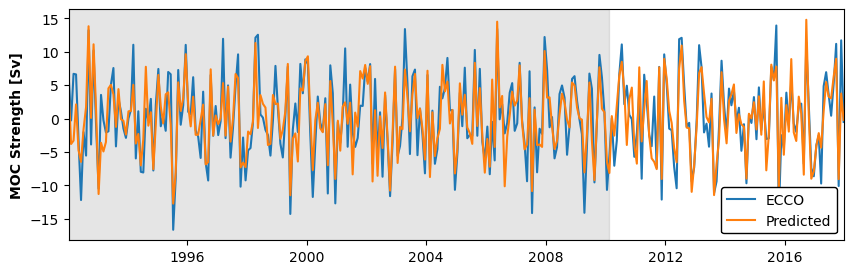

In [34]:
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

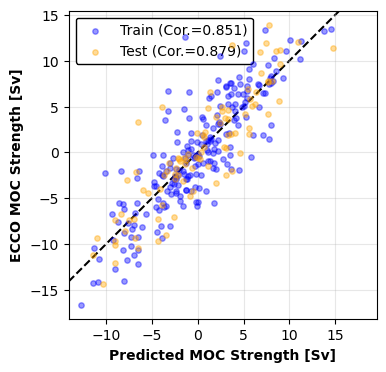

In [35]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
plt.show()